In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
import cone_prog_refine as cpr 
import time

import cvxpy as cvx
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Implement algorithm from paper (plus warmstart)

http://web.stanford.edu/~boyd/papers/pdf/mf_equil.pdf 

In [2]:
# u = np.arange(-10,10)
# M=5
# u = np.minimum(u, M)
# u = np.maximum(u, -M)
# u

In [160]:
#A,b,c,dims,x_true,s_true,y_true = cpr.generate_problem(mode='solvable')
m,n = A.shape
A /= np.sqrt(A.nnz)
caches = cpr.make_prod_cone_cache(dims)
z = np.ones(n+m+1)

In [161]:
z = cpr.scs_solve(A,b,c,dims)[0]

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 460497, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1029, constraints m = 1328
Cones:	primal zero / dual free vars: 36
	linear vars: 48
	soc vars: 893, soc blks: 75
	sd vars: 315, sd blks: 17
	exp vars: 21, dual exp vars: 15
Setup time: 1.48e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.31e+01  1.90e-01  9.82e-01 -4.23e+03 -3.71e+01  1.46e-12  3.91e-02 
   100| 1.25e-02  1.51e-04  2.85e-04 -2.85e-01

In [162]:
from scipy.sparse.linalg import lsqr, LinearOperator


residual, u, v = cpr.residual_and_uv(z,(A.indptr, A.indices,
                                             A.data),b,c,caches)

D = LinearOperator((m + n + 1, m + n + 1),
                   matvec=lambda dz: cpr.lsqr_D(
    z, np.array(dz).flatten(), (A.indptr, A.indices,A.data),  b, c, caches, residual),
    rmatvec=lambda dres: cpr.lsqr_DT(
    z, np.array(dres).flatten(), (A.indptr, A.indices,A.data), b, c, caches, residual)
)

In [174]:
import scipy.sparse as sp

u,s,v = sp.linalg.svds(D, k=1)

In [175]:
s

array([15.03955371])

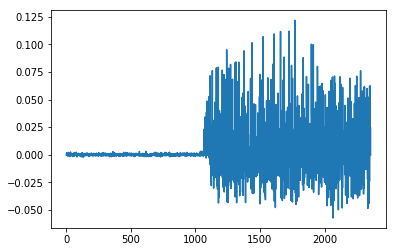

In [167]:
plt.plot(u[:,-1])

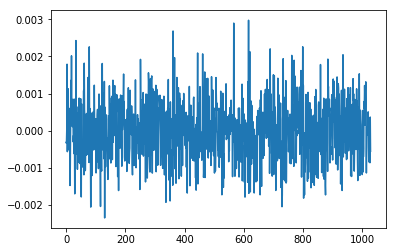

In [168]:
plt.plot(u[0:n, -1])

In [169]:
v[-1]

array([ 6.99471332e-05, -9.41816948e-06,  3.73039616e-05, ...,
        1.65790731e-03, -2.08120476e-06,  9.97789134e-01])

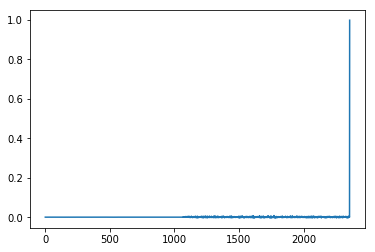

In [170]:
plt.plot(v[-1])

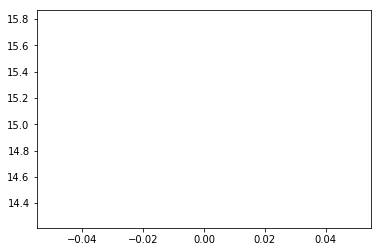

In [171]:
plt.plot(s)

In [176]:
result = lsqr(D, residual, show=True)
step = result[0]

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     2358 rows  and     2358 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     4716
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.605e-05  4.605e-05    1.0e+00  1.1e+04
     1 -1.15774e-07   3.196e-05  3.196e-05    6.9e-01  3.8e+00   7.2e-01  1.0e+00
     2 -1.19741e-07   3.139e-05  3.139e-05    6.8e-01  2.9e-02   1.5e+01  2.1e+01
     3 -2.13075e-07   2.552e-05  2.552e-05    5.5e-01  1.7e-02   1.5e+01  3.2e+01
     4 -3.29533e-07   2.243e-05  2.243e-05    4.9e-01  1.1e-02   1.5e+01  4.5e+01
     5 -3.83083e-07   2.155e-05  2.155e-05    4.7e-01  7.5e-03   1.5e+01  5.4e+01
     6 -4.31013e-07   2.119e-05  2.119e-05    4.6e-01  5.1e-02   1.5e+01  6.3e+01
     7 -4.34977e-07   2.116e-05  2.116e-05    4.6e-01  3.7e-03   2.1e+01  8.9e+01
     8 -5.12693e-07   2.091e

In [7]:
# from scipy.sparse.linalg import lsqr, LinearOperator

# class Q_LinOp(LinearOperator):
    
#     def __init__(self, A,b,c):
#         self.A = A
#         self.b = b
#         self.c = c
        
#     @property
#     def shape(self):
#         n = sum(self.A.shape) + 1
#         return (n, n)
        
#     def _matvec(self, u):
#         return cpr.Q_matvec((self.A.indptr, self.A.indices, self.A.data), 
#                             self.b, 
#                             self.c, np.array(u).flatten())
    
#     def _rmatvec(self, v):
#         return - cpr.Q_matvec((self.A.indptr, self.A.indices, self.A.data), 
#                             self.b, 
#                             self.c, np.array(v).flatten())

# Q = Q_LinOp(A,b,c)
# #Q.shape

# lsqr(Q, b, show=True)

In [177]:
n = D.shape[0]
random_passes = [D @ np.random.uniform(-1,1,n) for i in range(1000)]

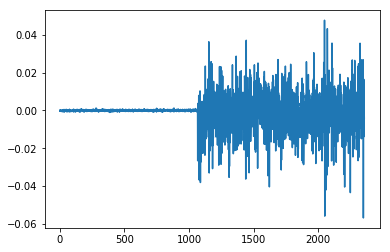

In [178]:
plt.plot(np.array(random_passes).mean(0))

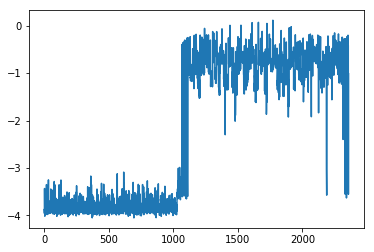

In [181]:
plt.plot(np.log10((np.array(random_passes)**2).mean(0)))

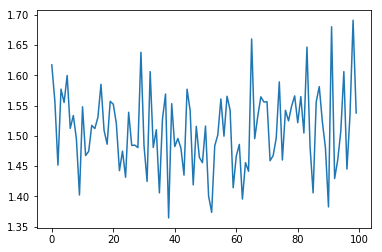

In [186]:
## what happens with random matrix?

C = np.random.randn(100,100)
random_passes = [C @ np.random.uniform(-1,1,100) for i in range(1000)]
plt.plot(np.log10((np.array(random_passes)**2).mean(0)))

In [182]:
import scipy.sparse as sp
import numpy as np

def equilibrate_square_linop(linop, u_0, gamma=0.1, M=np.log(1E1), T=1000):
    n = len(u_0)
    u = np.array(u_0)
    running_mean = np.zeros(n)
    for t in range(T):
        D = sp.diags(np.exp(u))
        s = np.random.uniform(-1,1,n)
        step = np.abs(D @ (linop @ (D @ s)))**2 - np.ones(n)
        print(step)
        u = (u - 2 * (step + gamma * u)) / (gamma * (t+1))
        u = np.minimum(u, M)
        u = np.maximum(u, -M)
        running_mean = 2 * u / (t + 2) + t * running_mean / (t + 2)
        
    return sp.diags(np.exp(running_mean))
        

In [183]:
my_eq = equilibrate_square_linop(D, np.zeros(sum(A.shape)+1) , T=100)

[-0.99999988 -0.99946144 -0.999922   ... -0.94823759 -0.99918989
 -0.995774  ]
[ 3.70135786e-01 -7.44717092e-01 -9.95726019e-01 ...  3.11315416e+03
  1.08894698e+00  1.07525906e+03]
[-0.91755096 -0.8500393  -0.99976066 ... -0.99999719 -0.99982546
 -0.99794572]
[-0.95587187 -0.78791199 -0.98024706 ...  7.29647281  0.02224392
 -0.20866668]
[  1.88655373  -0.92325943  -0.83523147 ...  -0.92963517   5.15597418
 187.42734792]
[-0.99999574 -0.93617766 -0.95968986 ... -0.70540168 -0.99962821
 -0.99500539]
[ -0.99809703   0.23891515  -0.99968626 ... 117.37696025  -0.98731516
  -0.18315822]
[-0.98573571 -0.9646638   0.86866476 ... -0.99372953  9.39490172
 11.49619294]
[-0.89098445 -0.18147867 -0.99964041 ... -0.80613763 -0.99985169
 -0.94688589]
[-9.97455341e-01 -9.97078839e-01 -9.43134792e-01 ...  1.74115546e+03
 -9.97237192e-01 -9.63644697e-01]
[-9.39310741e-01 -6.26919362e-01 -9.88177213e-01 ... -9.34018960e-01
 -7.90602236e-01  8.29627715e+02]
[-0.88603632 -0.99999151 -0.99896311 ... -0.748

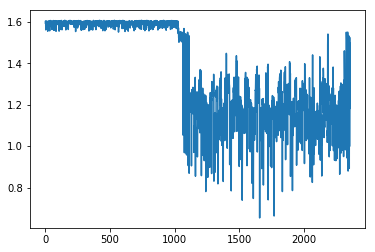

In [184]:
plt.plot(my_eq.diagonal())

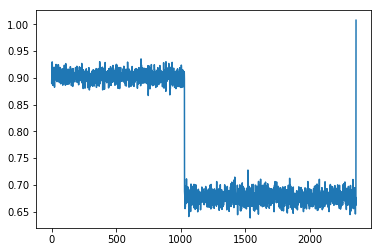

In [131]:
plt.plot(my_eq.diagonal())

In [123]:
# restarted_eq = equilibrate_square_linop(D, my_eq.diagonal(), T = 10)
# plt.plot(restarted_eq.diagonal())

In [127]:
def preconditioned_sq_linop(precond, linop):
    return LinearOperator(linop.shape,
                   matvec=lambda dz: linop.matvec(precond @ dz),
                  rmatvec=lambda dz: linop.rmatvec(precond @ dz))

precond_D = preconditioned_sq_linop(my_eq, D)

In [128]:
u,s,v = sp.linalg.svds(precond_D, k=100)

u_or,s_or,v_or = sp.linalg.svds(D, k=100)

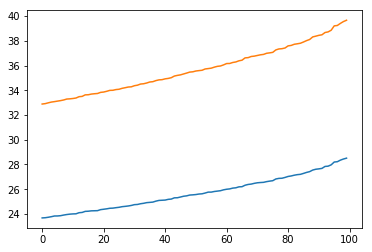

In [129]:
plt.plot(s)
plt.plot(s_or)

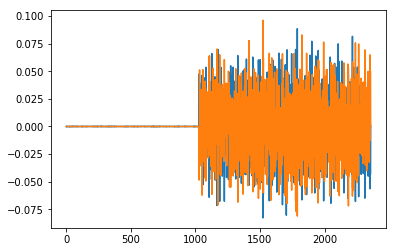

In [120]:
plt.plot(u[:,-1])
plt.plot(u_or[:,-1])

In [62]:
def preconditioned_sq_linop(precond, linop):
    return LinearOperator(linop.shape,
                   matvec=lambda dz: linop.matvec(precond @ dz),
                  rmatvec=lambda dz: linop.rmatvec(precond @ dz))

In [63]:
equilibrated_D = preconditioned_sq_linop(my_eq, D)
result = lsqr(equilibrated_D, my_eq @ residual, show=True)
step_precond = result[0]

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     2358 rows  and     2358 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     4716
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.714e-06  3.714e-06    1.0e+00  5.6e+05
     1 -6.60375e-09   3.292e-06  3.292e-06    8.9e-01  2.6e-01   4.5e+00  1.0e+00
     2 -1.24333e-08   3.155e-06  3.155e-06    8.5e-01  9.3e-02   6.5e+00  2.7e+00
     3 -1.44043e-08   3.133e-06  3.133e-06    8.4e-01  5.7e-02   8.5e+00  4.3e+00
     4 -1.56259e-08   3.124e-06  3.124e-06    8.4e-01  3.6e-02   1.1e+01  6.8e+00
     5 -1.67045e-08   3.118e-06  3.118e-06    8.4e-01  2.3e-02   1.4e+01  1.0e+01
     6 -1.74842e-08   3.114e-06  3.114e-06    8.4e-01  1.6e-02   1.6e+01  1.4e+01
     7 -1.78679e-08   3.112e-06  3.112e-06    8.4e-01  1.2e-02   1.9e+01  1.8e+01
     8 -1.80458e-08   3.111e

  4703 -2.32380e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4704 -2.32384e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4705 -2.32387e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4706 -2.32391e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4707 -2.32395e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4708 -2.32398e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4709 -2.32402e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4710 -2.32406e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4711 -2.32409e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4712 -2.32413e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4713 -2.32417e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4714 -2.32420e-08   3.109e-06  3.109e-06    8.4e-01  9.7e-08   3.4e+05  1.5e+07
  4715 -2.32424e

In [70]:
sp.diags(1./my_eq.diagonal())

<2358x2358 sparse matrix of type '<class 'numpy.float64'>'
	with 2358 stored elements (1 diagonals) in DIAgonal format>

In [73]:
z = z - sp.diags(1./my_eq.diagonal()) @ step_precond

residual, u, v = cpr.residual_and_uv(z,(A.indptr, A.indices,
                                             A.data),b,c,caches)

D = LinearOperator((m + n + 1, m + n + 1),
                   matvec=lambda dz: cpr.lsqr_D(
    z, np.array(dz).flatten(), (A.indptr, A.indices,A.data),  b, c, caches, residual),
    rmatvec=lambda dres: cpr.lsqr_DT(
    z, np.array(dres).flatten(), (A.indptr, A.indices,A.data), b, c, caches, residual)
)

In [74]:
result = lsqr(D, residual, show=True)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has     2358 rows  and     2358 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     4716
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.217e-04  4.217e-04    1.0e+00  5.4e+04
     1 -9.30438e-08   1.720e-04  1.720e-04    4.1e-01  6.3e-01   2.5e+01  1.0e+00
     2 -1.63796e-08   1.043e-04  1.043e-04    2.5e-01  6.4e-01   3.3e+01  2.2e+00
     3 -1.10757e-07   7.198e-05  7.198e-05    1.7e-01  3.6e-01   4.6e+01  3.7e+00
     4 -8.12649e-08   4.836e-05  4.836e-05    1.1e-01  2.8e-01   5.4e+01  5.2e+00
     5 -8.23175e-08   3.966e-05  3.966e-05    9.4e-02  1.9e-01   6.2e+01  6.6e+00
     6 -8.78205e-08   3.436e-05  3.436e-05    8.1e-02  1.2e-01   6.8e+01  8.2e+00
     7 -7.79954e-08   3.253e-05  3.253e-05    7.7e-02  7.8e-02   7.3e+01  9.6e+00
     8 -8.54274e-08   3.145e

In [32]:
my_eq.diagonal()

array([1.01177469e-04, 1.01311889e-04, 1.01570559e-04, ...,
       1.00909809e-04, 1.00788279e-04, 9.10059431e+03])

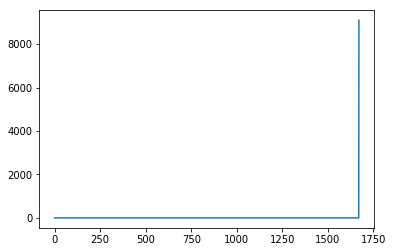

In [31]:
plt.plot(my_eq.diagonal())

In [ ]:
from 

In [9]:
np.random.uniform(-1,1,10)

array([-0.31545385,  0.70223802,  0.06034984,  0.87606024, -0.38208967,
       -0.98953572, -0.78682413, -0.86230549,  0.98613667, -0.0882451 ])

In [5]:
sp.diags(range(10)).todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 6., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 7., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 8., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 9.]])

In [42]:
b /= 150
c /= 150
scs_solution = cpr.scs_solve(A,b,c,dims, verbose=True)[0]

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 103007, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 495, constraints m = 686
Cones:	primal zero / dual free vars: 17
	linear vars: 33
	soc vars: 636, soc blks: 53
Setup time: 4.68e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.52e+03  6.73e+01  6.79e-01 -5.33e+01 -9.77e+00  8.82e-15  3.89e-02 
    40| 4.25e-06  2.27e-07  1.15e-09  3.45e-06  3.44e-06  2.39e-19  1.98e-01 
------------------------------

In [45]:
cpr.ADMM_refine(A,b,c,dims, scs_solution, lsqr_iters=30, iters=10)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	4.59e-06	1e+00		0	0.00
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1182 rows  and 1182 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.594e-06  4.594e-06    1.0e+00  1.4e+05
     1  4.30163e-10   3.412e-06  3.412e-06    7.4e-01  2.3e-01   9.6e-01  1.0e+00
     2  2.08582e-08   3.034e-06  3.034e-06    6.6e-01  1.4e-01   1.1e+00  2.6e+00
     3  3.92269e-08   2.915e-06  2.915e-06    6.3e-01  7.5e-02   1.3e+00  4.1e+00
     4  5.37

 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.667e-07  2.667e-07    1.0e+00  1.3e+05
     1  1.09906e-12   2.664e-07  2.664e-07    1.0e+00  2.0e-02   8.8e-01  1.0e+00
     2  1.40854e-10   2.661e-07  2.661e-07    1.0e+00  2.2e-02   1.0e+00  3.5e+00
     3  5.60050e-10   2.655e-07  2.655e-07    1.0e+00  2.9e-02   1.2e+00  7.2e+00
     4  1.32621e-09   2.648e-07  2.648e-07    9.9e-01  2.4e-02   1.4e+00  1.2e+01
     5  2.54610e-09   2.639e-07  2.639e-07    9.9e-01  2.0e-02   1.5e+00  1.7e+01
     6  3.94583e-09   2.634e-07  2.634e-07    9.9e-01  2.0e-02   1.6e+00  2.0e+01
     7  5.14586e-09   2.630e-07  2.630e-07    9.9e-01  1.9e-02   1.8e+00  2.5e+01
     8  8.92857e-09   2.619e-07  2.619e-07    9.8e-01  1.7e-02   1.9e+00  3.2e+01
     9  1.37389e-08   2.608e-07  2.608e-07    9.8e-01  1.5e-02   2.0e+00  3.8e+01
    10  1.69831e-08   2.601e-07  2.601e-07    9.8e-01  1.2e-02   2.1e+00  4.3e+01
    20  5.70704e-08   2.571e-07  2

     9 -1.95752e-08   2.164e-07  2.164e-07    9.9e-01  9.7e-03   1.9e+00  4.2e+01
    10 -2.15100e-08   2.162e-07  2.162e-07    9.9e-01  6.5e-03   2.1e+00  4.7e+01
    20 -2.39083e-08   2.152e-07  2.152e-07    9.9e-01  5.3e-03   2.9e+00  1.0e+02
    21 -2.11896e-08   2.149e-07  2.149e-07    9.9e-01  6.0e-03   3.0e+00  1.1e+02
    22 -1.59133e-08   2.146e-07  2.146e-07    9.8e-01  6.7e-03   3.0e+00  1.2e+02
    23 -1.07966e-08   2.143e-07  2.143e-07    9.8e-01  6.9e-03   3.1e+00  1.4e+02
    24 -8.23500e-09   2.141e-07  2.141e-07    9.8e-01  6.7e-03   3.2e+00  1.5e+02
    25 -5.19430e-09   2.140e-07  2.140e-07    9.8e-01  5.3e-03   3.3e+00  1.6e+02
    26  6.19424e-10   2.137e-07  2.137e-07    9.8e-01  6.0e-03   3.3e+00  1.7e+02
    27  5.56515e-09   2.135e-07  2.135e-07    9.8e-01  5.9e-03   3.4e+00  1.8e+02
    28  1.00254e-08   2.133e-07  2.133e-07    9.8e-01  4.3e-03   3.4e+00  1.9e+02
    29  1.25205e-08   2.132e-07  2.132e-07    9.8e-01  3.1e-03   3.5e+00  1.9e+02
    30  1.45147e

array([-3.94837740e-03, -2.73657592e-03,  5.02116700e-03, ...,
        2.97572578e-03, -4.53685480e-04,  1.00000000e+00])

In [40]:
z_init = np.random.randn(len(scs_solution))
cpr.ADMM_refine(A,b,c,dims, z_init, lsqr_iters=30, iters=10)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	1.44e+01	1e+00		0	0.00
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1335 rows  and 1335 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.438e+01  1.438e+01    1.0e+00  6.8e-01
     1 -2.11322e-04   7.526e-02  7.526e-02    5.2e-03  2.4e-03   9.8e+00  1.0e+00
     2 -1.59682e-04   7.488e-02  7.488e-02    5.2e-03  3.4e-03   9.8e+00  4.2e+01
     3 -2.43389e-04   7.446e-02  7.446e-02    5.2e-03  5.0e-03   9.8e+00  6.8e+01
     4 -4.36

    20 -2.78846e-02   6.456e-02  6.456e-02    3.8e-02  3.8e-02   3.6e-01  1.1e+02
    21 -2.12759e-02   6.412e-02  6.412e-02    3.8e-02  1.8e-02   4.0e-01  1.2e+02
    22 -1.04321e-02   6.344e-02  6.344e-02    3.7e-02  1.5e-02   4.1e-01  1.3e+02
    23 -3.16490e-03   6.300e-02  6.300e-02    3.7e-02  9.9e-03   4.1e-01  1.4e+02
    24  5.10402e-04   6.280e-02  6.280e-02    3.7e-02  8.4e-03   4.2e-01  1.4e+02
    25  2.75277e-03   6.267e-02  6.267e-02    3.7e-02  6.4e-03   4.2e-01  1.5e+02
    26  5.81889e-03   6.252e-02  6.252e-02    3.7e-02  6.4e-03   4.3e-01  1.5e+02
    27  8.72768e-03   6.238e-02  6.238e-02    3.7e-02  6.1e-03   4.3e-01  1.6e+02
    28  1.22094e-02   6.225e-02  6.225e-02    3.6e-02  7.3e-03   4.4e-01  1.6e+02
    29  1.56115e-02   6.211e-02  6.211e-02    3.6e-02  7.1e-03   4.4e-01  1.7e+02
    30  1.98902e-02   6.193e-02  6.193e-02    3.6e-02  1.3e-02   4.5e-01  1.7e+02
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1n

    10  7.46749e-02   4.018e-02  4.018e-02    7.9e-02  4.2e-02   9.4e-02  3.6e+01
    20  4.95563e-02   3.569e-02  3.569e-02    7.0e-02  2.3e-02   1.3e-01  8.3e+01
    21  4.23663e-02   3.538e-02  3.538e-02    7.0e-02  1.5e-02   1.3e-01  8.9e+01
    22  3.57884e-02   3.514e-02  3.514e-02    6.9e-02  2.0e-02   1.3e-01  9.3e+01
    23  2.93521e-02   3.491e-02  3.491e-02    6.9e-02  2.2e-02   1.4e-01  9.8e+01
    24  2.25229e-02   3.462e-02  3.462e-02    6.8e-02  1.7e-02   1.4e-01  1.0e+02
    25  1.97592e-02   3.444e-02  3.444e-02    6.8e-02  1.8e-02   1.5e-01  1.1e+02
    26  1.67673e-02   3.405e-02  3.405e-02    6.7e-02  1.7e-02   1.5e-01  1.2e+02
    27  1.77431e-02   3.377e-02  3.377e-02    6.7e-02  1.9e-02   1.5e-01  1.2e+02
    28  2.06069e-02   3.343e-02  3.343e-02    6.6e-02  1.6e-02   1.5e-01  1.3e+02
    29  2.52371e-02   3.308e-02  3.308e-02    6.5e-02  1.9e-02   1.6e-01  1.4e+02
    30  2.84673e-02   3.285e-02  3.285e-02    6.5e-02  1.1e-02   1.6e-01  1.4e+02
 
LSQR finished


array([-0.00610206,  0.01752762,  0.00565233, ...,  0.10056275,
        0.08003391,  1.        ])

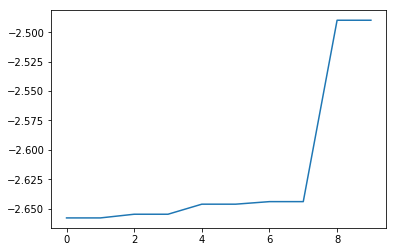

In [19]:
from scipy.sparse.linalg import LinearOperator, svds

Q = LinearOperator(shape = (len(b ) + len(c) + 1, len(b ) + len(c) + 1),
               matvec = lambda u: cpr.Q_matvec((A.indptr, A.indices, A.data), b,c, np.array(u).flatten()),
               rmatvec = lambda v: cpr.Q_rmatvec((A.indptr, A.indices, A.data), b,c,np.array(v).flatten())
              )
u, s, v = svds(Q, k = 10, which='LM')

plt.plot(np.log(s))

In [20]:
#s[-2]/s[-3]

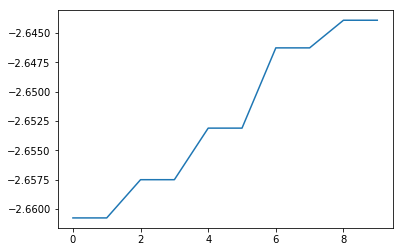

In [21]:
def matvec(u): 
    my_u= np.array(u).flatten()
    my_u[-1] /= 153
    result = cpr.Q_matvec((A.indptr, A.indices, A.data), b,c, my_u)
    result[-1] /= 153
    return result

def rmatvec(v): 
    return - matvec(v)
#     my_v= np.array(v).flatten()
#     my_v[-1] /= 10000
#     return cpr.Q_rmatvec((A.indptr, A.indices, A.data), b,c, my_v)

precond_Q = LinearOperator((len(b ) + len(c) + 1, len(b ) + len(c) + 1), matvec, rmatvec)
u, s, v = svds(precond_Q, k = 10, which='LM')

plt.plot(np.log(s))

In [16]:
#s

In [13]:
#np.linalg.norm(np.concatenate([b,c]))

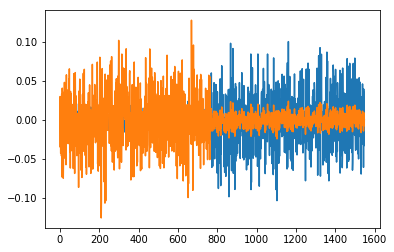

In [22]:
plt.plot(u[:,-1])
plt.plot(u[:,-2])

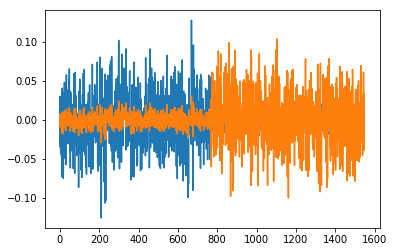

In [23]:
plt.plot(v[-1])
plt.plot(v[-2])

In [291]:
#s

array([ 0.06333893,  0.06362414,  0.06362414, 13.92137905, 13.92137905])

In [24]:
#plt.plot(np.log(s))

In [25]:
#LinearOperator?

In [26]:
cpr.refine(A,b,c,dims, scs_solution, lsqr_iters=30, iters=10)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	5.76e-07	1e+00		0	0.00
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1549 rows  and 1549 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.756e-07  5.756e-07    1.0e+00  6.8e+05
     1  7.87335e-11   5.250e-07  5.250e-07    9.1e-01  1.4e-01   9.5e-01  1.0e+00
     2 -5.34410e-10   4.790e-07  4.790e-07    8.3e-01  1.4e-01   1.0e+00  3.6e+00
     3 -7.56225e-10   4.664e-07  4.664e-07    8.1e-01  8.8e-02   1.3e+00  5.2e+00
     4 -1.67

    20  1.20993e-08   4.631e-08  4.631e-08    9.5e-01  1.1e-02   3.0e+00  9.5e+01
    21  1.25217e-08   4.622e-08  4.622e-08    9.5e-01  1.2e-02   3.1e+00  1.0e+02
    22  1.29625e-08   4.611e-08  4.611e-08    9.5e-01  1.0e-02   3.2e+00  1.1e+02
    23  1.33171e-08   4.601e-08  4.601e-08    9.5e-01  9.9e-03   3.3e+00  1.1e+02
    24  1.36130e-08   4.592e-08  4.592e-08    9.4e-01  8.7e-03   3.4e+00  1.2e+02
    25  1.38738e-08   4.583e-08  4.583e-08    9.4e-01  8.8e-03   3.4e+00  1.3e+02
    26  1.41605e-08   4.572e-08  4.572e-08    9.4e-01  9.5e-03   3.5e+00  1.3e+02
    27  1.44938e-08   4.558e-08  4.558e-08    9.4e-01  1.0e-02   3.5e+00  1.4e+02
    28  1.47506e-08   4.546e-08  4.546e-08    9.3e-01  1.2e-02   3.6e+00  1.5e+02
    29  1.50124e-08   4.534e-08  4.534e-08    9.3e-01  9.9e-03   3.7e+00  1.6e+02
    30  1.53226e-08   4.516e-08  4.516e-08    9.3e-01  1.1e-02   3.8e+00  1.7e+02
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1n

array([1.40806504e-01, 1.00690366e-01, 1.12942269e-01, ...,
       6.59165272e-04, 2.64445034e-03, 1.00000000e+00])

In [30]:
cpr.ADMM_refine(A,b,c,dims, scs_solution, lsqr_iters=30, iters=10, U_UPDATE=5)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	5.76e-07	1e+00		0	0.00
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1549 rows  and 1549 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.756e-07  5.756e-07    1.0e+00  6.8e+05
     1  7.87335e-11   5.250e-07  5.250e-07    9.1e-01  1.4e-01   9.5e-01  1.0e+00
     2 -5.34410e-10   4.790e-07  4.790e-07    8.3e-01  1.4e-01   1.0e+00  3.6e+00
     3 -7.56225e-10   4.664e-07  4.664e-07    8.1e-01  8.8e-02   1.3e+00  5.2e+00
     4 -1.67

    20 -7.79425e-09   5.000e-08  5.000e-08    9.2e-01  1.4e-02   3.1e+00  8.3e+01
    21 -8.17611e-09   4.986e-08  4.986e-08    9.2e-01  1.2e-02   3.2e+00  8.9e+01
    22 -8.59420e-09   4.969e-08  4.969e-08    9.1e-01  9.8e-03   3.2e+00  9.5e+01
    23 -8.88682e-09   4.955e-08  4.955e-08    9.1e-01  9.3e-03   3.3e+00  1.0e+02
    24 -9.17989e-09   4.938e-08  4.938e-08    9.1e-01  9.8e-03   3.3e+00  1.1e+02
    25 -9.37267e-09   4.923e-08  4.923e-08    9.0e-01  1.1e-02   3.4e+00  1.1e+02
    26 -9.45844e-09   4.912e-08  4.912e-08    9.0e-01  1.0e-02   3.5e+00  1.2e+02
    27 -9.47651e-09   4.900e-08  4.900e-08    9.0e-01  9.9e-03   3.6e+00  1.2e+02
    28 -9.39987e-09   4.889e-08  4.889e-08    9.0e-01  9.6e-03   3.6e+00  1.3e+02
    29 -9.22925e-09   4.877e-08  4.877e-08    9.0e-01  8.6e-03   3.7e+00  1.4e+02
    30 -8.92590e-09   4.864e-08  4.864e-08    8.9e-01  9.6e-03   3.7e+00  1.4e+02
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1n

    29  1.31164e-08   7.596e-08  7.596e-08    9.7e-01  7.3e-03   3.7e+00  1.7e+02
    30  1.31766e-08   7.579e-08  7.579e-08    9.7e-01  8.5e-03   3.8e+00  1.8e+02
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 7.6e-08   anorm = 3.8e+00   arnorm = 2.4e-09
itn   =      30   r2norm = 7.6e-08   acond = 1.8e+02   xnorm  = 8.2e-07
 
10	3.86e-08	7.58e-08	1e+00		30	0.86
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


array([1.40806509e-01, 1.00690363e-01, 1.12942264e-01, ...,
       6.59169585e-04, 2.64445260e-03, 1.00000000e+00])

In [191]:
#scs_solution = Out[188][0]

In [192]:
# # without ADMM
# z_init = np.ones(len(b) + len(c) + 1)
# cpr.refine(A,b,c,dims, z_init, lsqr_iters=20, iters=1000)

In [193]:
#non_admm_z = Out[164]

In [246]:
# with ADMM
#admm_z = np.ones(len(b) + len(c) + 1)
admm_z = cpr.ADMM_refine(A,b,c,dims, admm_z, lsqr_iters=1000, iters=10, U_UPDATE=1)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	1.76e-04	1e+00		0	0.00
1	1.41e-04	1.41e-04	1e+00		1000	1.76
2	1.40e-04	2.34e-04	1e+00		1000	3.48
3	1.20e-04	3.41e-04	1e+00		1000	5.20
4	1.17e-04	4.45e-04	1e+00		1000	6.92
5	1.17e-04	5.45e-04	1e+00		1000	8.60
6	1.18e-04	6.39e-04	1e+00		1000	10.27
7	1.22e-04	7.29e-04	1e+00		1000	12.00
8	1.20e-04	8.11e-04	1e+00		1000	13.67
9	1.21e-04	8.91e-04	1e+00		1000	15.36
10	1.18e-04	9.64e-04	1e+00		1000	17.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Max num. refinement iters reached.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [233]:
admm_z = Out[165]

In [186]:
cpr.ADMM_refine(A,b,c,dims, admm_z, lsqr_iters=100, iters=100, U_UPDATE=1)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Conic Solution Refinement              

           (Enzo Busseti 𝘦𝘵 𝘢𝘭., 2017-2019)            
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ite.    || N(z) ||_2      z[-1]     LSQR       time
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0	6.51e-04	1e+00		0	0.00
1	6.36e-04	6.36e-04	1e+00		100	0.20
2	6.36e-04	1.27e-03	1e+00		100	0.38
3	6.35e-04	1.90e-03	1e+00		100	0.57
4	6.34e-04	2.52e-03	1e+00		100	0.76
5	6.34e-04	3.15e-03	1e+00		100	0.94
6	6.35e-04	3.76e-03	1e+00		100	1.12
7	6.36e-04	4.37e-03	1e+00		100	1.32
8	6.59e-04	4.97e-03	1e+00		100	1.49
9	6.50e-04	5.56e-03	1e+00		100	1.67
10	6.29e-04	6.15e-03	1e+00		100	1.86
11	6.29e-04	6.72e-03	1e+00		100	2.12
12	6.37e-04	7.29e-03	1e+00		100	2.30
13	6.39e-04	7.84e-03	1e+00		100	2.52
14	6.90e-04	8.39e-03	1e+00		100	2.70
15	6.71e-04	8.92e-03	1e+00		100	2.91
16	6.26e-04	9.44e-03	1e+00		100	3.08
17	6.21e-04	9.95e-03	1e+00		100	3.29
18	6.23e-04	1.05e-02	1e+00		

array([-0.60662387, -0.14776429,  0.68150117, ..., -0.26914424,
        0.10257168,  1.        ])

In [171]:
#z_init = cpr.ADMM_refine(A,b,c,dims, z_init, lsqr_iters=30, iters=100, U_UPDATE=1)

In [172]:
#z_init = cpr.refine(A,b,c,dims, z_init, lsqr_iters=12, iters=30)#, U_UPDATE=5)

In [109]:
#cpr.refine(A,b,c,dims, z_init, lsqr_iters=3, iters=100)

In [110]:
#z_init = cpr.refine(A,b,c,dims, z_init, lsqr_iters=3, iters=200)

In [111]:
#z_init = cpr.ADMM_refine(A,b,c,dims, z_init, lsqr_iters=1, iters=100, U_UPDATE=40)

In [112]:
#z_init = cpr.refine(A,b,c,dims, z_init, lsqr_iters=30, iters=100)